In [65]:
import os
import geopandas as gpd
import folium
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

# Folder containing GeoJSONs -- CHANGE THIS
geojson_folder = "Oregon_700k(25)"
geojson_files = [f for f in os.listdir(geojson_folder) if f.endswith("Corvallis.geojson")]

# Set up colors for layers
colors = [
    "red","blue","green","purple","orange","darkred","lightred","black",
    "darkblue","darkgreen","cadetblue","pink","lightblue","gray","beige"
]

# --- Compute overall bounds for base map ---
all_bounds = []
for file in geojson_files:
    gdf = gpd.read_file(os.path.join("","corvallis_removed_smallest.geojson")).to_crs(4326)
    all_bounds.append(gdf.total_bounds)

minx = min(b[0] for b in all_bounds)
miny = min(b[1] for b in all_bounds)
maxx = max(b[2] for b in all_bounds)
maxy = max(b[3] for b in all_bounds)

# --- Base Folium map ---
m = folium.Map(
    location=[(miny+maxy)/2, (minx+maxx)/2],
    zoom_start=7
)

# --- Helper to style each GeoJSON ---
def make_style(color):
    return lambda feat: {
        "fillColor": color,
        "color": color,
        "weight": 2,
        "fillOpacity": 0.45
    }

# --- Add each GeoJSON to map ---
for i, file in enumerate(sorted(geojson_files)):
    gdf = gpd.read_file(os.path.join(geojson_folder, file)).to_crs(4326)

    # Merge geometries if multiple features exist
    merged_geom = unary_union(gdf.geometry)
    if merged_geom.geom_type == "GeometryCollection":
        polys = [g for g in merged_geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
        merged_geom = unary_union(polys)

    merged_gdf = gpd.GeoDataFrame(
        {
            "name": [file.replace(".geojson","")],
            "total_area_ft2": [gdf["total_area_ft2"].sum() if "total_area_ft2" in gdf else None]
        },
        geometry=[merged_geom],
        crs=4326
    )

    # Add to Folium
    color = colors[i % len(colors)]
    layer_name = f"{i+1}. {file.replace('.geojson','')}"
    folium.GeoJson(
        merged_gdf,
        name=layer_name,
        tooltip=f"{file.replace('.geojson','')}<br>{merged_gdf['total_area_ft2'].values[0]:,.0f} ft²" if "total_area_ft2" in gdf else file.replace('.geojson',''),
        style_function=make_style(color)
    ).add_to(m)

# --- Final map adjustments ---
m.fit_bounds([[miny, minx], [maxy, maxx]])
folium.LayerControl().add_to(m)

m


In [56]:
import geopandas as gpd
from shapely.ops import unary_union

# grab the multipolygon
geom = gdf.geometry.iloc[0]

# explode into individual polygons
polys = list(geom.geoms)

# put into a GeoDataFrame
poly_gdf = gpd.GeoDataFrame(
    geometry=polys,
    crs=gdf.crs
)

# project to meters for correct area
poly_gdf_m = poly_gdf.to_crs(epsg=3857)
poly_gdf_m["area_m2"] = poly_gdf_m.area
poly_gdf_m["area_ft2"] = poly_gdf_m["area_m2"] * 10.7639

# find smallest polygon
smallest_idx = poly_gdf_m["area_m2"].idxmin()
smallest_poly = poly_gdf_m.loc[smallest_idx]


Smallest polygon area: 81.91 ft² (7.61 m²)


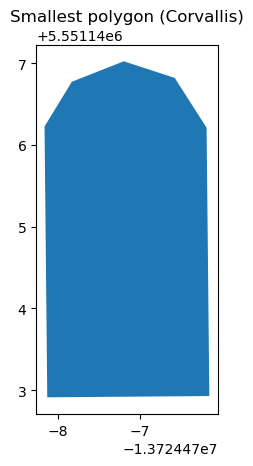

In [60]:
print(
    f"Smallest polygon area: "
    f"{smallest_poly.area_ft2:,.2f} ft² "
    f"({smallest_poly.area_m2:,.2f} m²)"
)

smallest_poly.geometry

smallest_poly_gdf = gpd.GeoDataFrame(
    geometry=[smallest_poly.geometry],
    crs=poly_gdf_m.crs
)

ax = smallest_poly_gdf.plot()
ax.set_title("Smallest polygon (Corvallis)")

# --- Base Folium map ---
m = folium.Map(
    location=[(miny+maxy)/2, (minx+maxx)/2],
    zoom_start=7
)
folium.GeoJson(
        smallest_poly_gdf,
        name=layer_name,
        tooltip=f"{file.replace('.geojson','')}<br>{merged_gdf['total_area_ft2'].values[0]:,.0f} ft²" if "total_area_ft2" in gdf else file.replace('.geojson',''),
        style_function=make_style(color)
    ).add_to(m)
m

In [61]:
remaining_polys = poly_gdf.drop(index=smallest_idx)

clean_geom = unary_union(remaining_polys.geometry)

clean_gdf = gpd.GeoDataFrame(
    gdf.drop(columns="geometry"),
    geometry=[clean_geom],
    crs=gdf.crs
)

clean_gdf.to_file(
    "corvallis_removed_smallest.geojson",
    driver="GeoJSON"
)


In [2]:
# Creating a histogram of shapes for California!

In [3]:
def auto_utm(gdf):
    gdf = gdf.to_crs("EPSG:4326")
    
    # Get centroid coordinates (in lon/lat)
    cent = gdf.to_crs(3857).centroid.to_crs(gdf.crs)
    lon = cent.x.mean()
    lat = cent.y.mean()

    # Compute UTM zone
    zone = int((lon + 180) / 6) + 1
    if lat >= 0:
        epsg = 32600 + zone  # Northern Hemisphere
    else:
        epsg = 32700 + zone  # Southern Hemisphere

    return epsg


In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

gdf = gpd.read_file("unified_geopackages_updated/state_06_unified.gpkg", layer = "unified_park_area")  # adjust path if needed
epsg = auto_utm(gdf)
gdf_utm = gdf.to_crs(epsg=epsg)
gdf_exploded = (
    gdf_utm
    .explode(index_parts=False)
    .reset_index(drop=True)
)
gdf_exploded["area_ft2"] = gdf_exploded.geometry.area * 10.7639



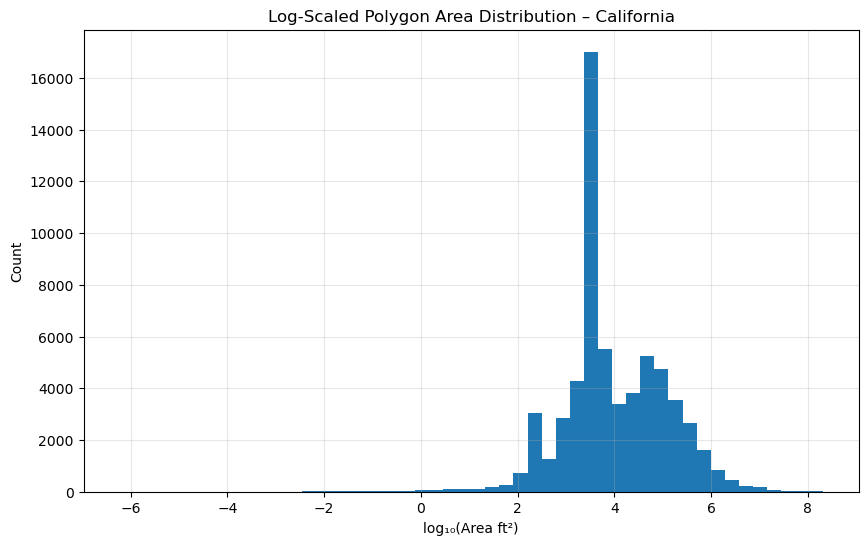

In [5]:
plt.figure(figsize=(10, 6))

plt.hist(
    np.log10(gdf_exploded["area_ft2"]),
    bins=50
)

plt.xlabel("log₁₀(Area ft²)")
plt.ylabel("Count")
plt.title("Log-Scaled Polygon Area Distribution – California")

plt.grid(alpha=0.3)
plt.show()


In [6]:
gdf_exploded["area_ft2"].describe()

count    6.266000e+04
mean     2.598571e+05
std      3.018300e+06
min      5.726599e-07
25%      2.745912e+03
50%      5.300810e+03
75%      5.801829e+04
max      2.100326e+08
Name: area_ft2, dtype: float64

In [7]:
# 95th, 99th, 99.9th together
gdf_exploded["area_ft2"].quantile([0.95, 0.99, 0.995, 0.999])


0.950    5.666471e+05
0.990    3.476650e+06
0.995    7.915515e+06
0.999    3.639239e+07
Name: area_ft2, dtype: float64

In [8]:
# Do it for the entire US

In [16]:
import glob
import geopandas as gpd
import pandas as pd
import numpy as np

gpkg_files = glob.glob("unified_geopackages_just_unified/state_*_unified.gpkg")

exploded_states = []

for gpkg in gpkg_files:
    try:
        # --- Load one state ---
        gdf = gpd.read_file(gpkg, layer="unified_park_area")
        gdf = gdf.set_crs("EPSG:4326", inplace = True, allow_override=True)

        # --- Explode within state ---
        gdf_exploded = (
            gdf
            .explode(index_parts=False)
            .reset_index(drop=True)
        )

        # --- Compute ONE UTM per state ---
        epsg = auto_utm(gdf_exploded)
        gdf_utm = gdf_exploded.to_crs(epsg=epsg)

        # --- Area in ft² ---
        gdf_exploded["area_ft2"] = gdf_utm.geometry.area * 10.7639

        exploded_states.append(gdf_exploded)

    except Exception as e:
        print(f"Failed to process {gpkg}: {e}")


In [24]:
all_areas = pd.concat(exploded_states, ignore_index=True)

# Remove bad values
areas = all_areas["area_ft2"].replace([np.inf, -np.inf], np.nan).dropna()
areas = areas[areas > 0]

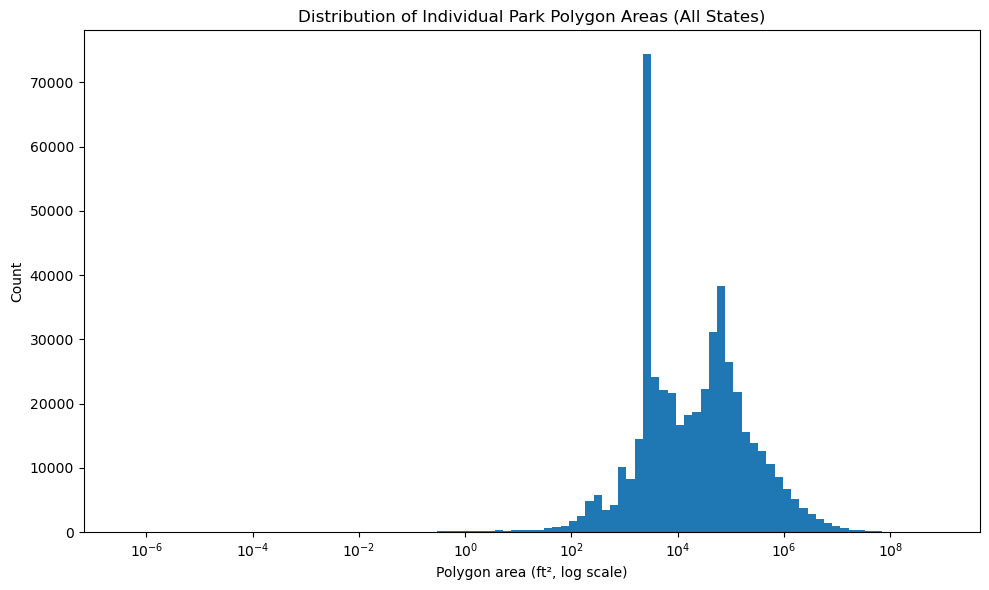

In [25]:
plt.figure(figsize=(10, 6))
bins = np.logspace(
    np.log10(areas.min()),
    np.log10(areas.max()),
    100
)

plt.hist(areas, bins=bins)
plt.xscale("log")
plt.xlabel("Polygon area (ft², log scale)")
plt.ylabel("Count")
plt.title("Distribution of Individual Park Polygon Areas (All States)")
plt.tight_layout()
plt.show()


In [26]:
areas.describe()

count    4.831940e+05
mean     3.159177e+05
std      3.517605e+06
min      3.857561e-07
25%      2.890593e+03
50%      1.987741e+04
75%      9.364531e+04
max      8.328896e+08
Name: area_ft2, dtype: float64

In [27]:
areas.quantile([0.95, 0.99, 0.995, 0.999])

0.950    9.692812e+05
0.990    4.842323e+06
0.995    8.452382e+06
0.999    2.949107e+07
Name: area_ft2, dtype: float64

In [36]:
import glob
import geopandas as gpd
import pandas as pd
import numpy as np

# -------------------------------------------------
# Northwest only (Group 1)
# -------------------------------------------------
group1_fips = {"30", "53", "41", "38", "16"}  
# MT, WA, OR, ND, ID

gpkg_files = glob.glob("unified_geopackages_just_unified/state_*_unified.gpkg")

exploded_states = []

for gpkg in gpkg_files:
    try:
        # --- Load one state ---
        gdf = gpd.read_file(gpkg, layer="unified_park_area")

        # Ensure CRS (DO NOT use inplace=True)
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)

        # -------------------------------------------------
        # Filter to Northwest states only
        # -------------------------------------------------
        gdf = gdf[gdf["state_fips"].astype(str).isin(group1_fips)]

        if gdf.empty:
            continue

        # --- Explode geometries ---
        gdf_exploded = (
            gdf
            .explode(index_parts=False)
            .reset_index(drop=True)
        )

        # --- Compute ONE UTM per state ---
        epsg = auto_utm(gdf_exploded)
        gdf_utm = gdf_exploded.to_crs(epsg=epsg)

        # --- Area in ft² ---
        gdf_exploded["area_ft2"] = gdf_utm.geometry.area * 10.7639

        exploded_states.append(gdf_exploded)

    except Exception as e:
        print(f"Failed to process {gpkg}: {e}")


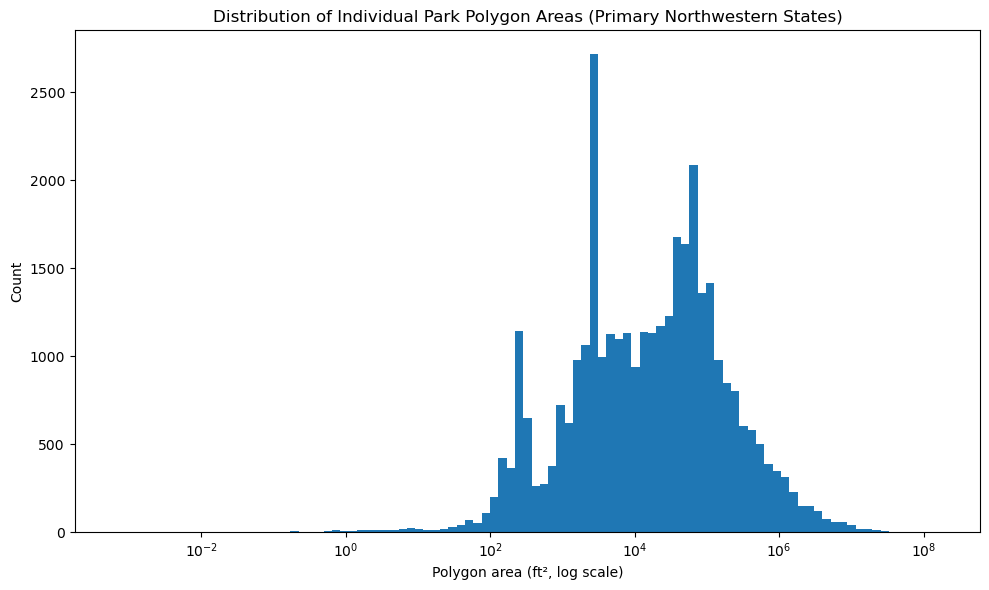

In [37]:
all_areas = pd.concat(exploded_states, ignore_index=True)

# Remove bad values
areas = all_areas["area_ft2"].replace([np.inf, -np.inf], np.nan).dropna()
areas = areas[areas > 0]
plt.figure(figsize=(10, 6))
bins = np.logspace(
    np.log10(areas.min()),
    np.log10(areas.max()),
    100
)

plt.hist(areas, bins=bins)
plt.xscale("log")
plt.xlabel("Polygon area (ft², log scale)")
plt.ylabel("Count")
plt.title("Distribution of Individual Park Polygon Areas (Primary Northwestern States)")
plt.tight_layout()
plt.show()


In [38]:
areas.quantile([0.95, 0.99, 0.995, 0.999])

0.950    7.441157e+05
0.990    3.544114e+06
0.995    6.350759e+06
0.999    1.848702e+07
Name: area_ft2, dtype: float64

In [77]:
import glob
import geopandas as gpd
import pandas as pd
import numpy as np

# -------------------------------------------------
# Northwest only (Group 1)
# -------------------------------------------------
group1_fips = {"30", "53", "41", "38", "16","56", "49", "08", "06", "32", "04", "35"}  # now both 
# MT, WA, OR, ND, ID

gpkg_files = glob.glob("unified_geopackages_just_unified/state_*_unified.gpkg")

exploded_states = []

for gpkg in gpkg_files:
    try:
        # --- Load one state ---
        gdf = gpd.read_file(gpkg, layer="unified_park_area")

        # Ensure CRS (DO NOT use inplace=True)
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)

        # -------------------------------------------------
        # Filter to Northwest states only
        # -------------------------------------------------
        gdf = gdf[~gdf["state_fips"].astype(str).isin(group1_fips)]

        if gdf.empty:
            continue

        # --- Explode geometries ---
        gdf_exploded = (
            gdf
            .explode(index_parts=False)
            .reset_index(drop=True)
        )

        # --- Compute ONE UTM per state ---
        epsg = auto_utm(gdf_exploded)
        gdf_utm = gdf_exploded.to_crs(epsg=epsg)

        # --- Area in ft² ---
        gdf_exploded["area_ft2"] = gdf_utm.geometry.area * 10.7639

        exploded_states.append(gdf_exploded)

    except Exception as e:
        print(f"Failed to process {gpkg}: {e}")


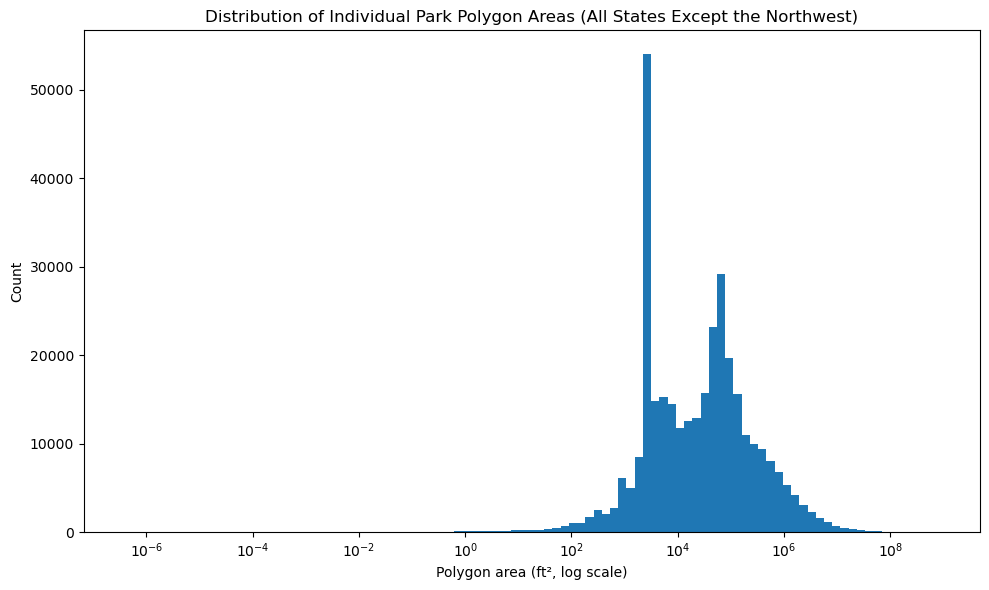

In [78]:
all_areas = pd.concat(exploded_states, ignore_index=True)

# Remove bad values
areas = all_areas["area_ft2"].replace([np.inf, -np.inf], np.nan).dropna()
areas = areas[areas > 0]
plt.figure(figsize=(10, 6))
bins = np.logspace(
    np.log10(areas.min()),
    np.log10(areas.max()),
    100
)

plt.hist(areas, bins=bins)
plt.xscale("log")
plt.xlabel("Polygon area (ft², log scale)")
plt.ylabel("Count")
plt.title("Distribution of Individual Park Polygon Areas (All States Except the Northwest)")
plt.tight_layout()
plt.show()

In [79]:
areas.quantile([0.95, 0.99, 0.995, 0.999])

0.950    1.123421e+06
0.990    5.279407e+06
0.995    8.878211e+06
0.999    2.961910e+07
Name: area_ft2, dtype: float64

In [80]:
areas_under_700k_sum = areas[areas < 700_000].sum()


In [81]:
areas_under_700k_sum

22031857238.97845

In [70]:
areas.sum()

38038864764.446175